Note to self: float32 is NOT enough to achieve reasonable numerical stability in the Gram-Schmidt step!

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def decompose(signal, harmonics):
    # assumes harmonics are orthonormalized
    return torch.tensor([torch.tensor(signal).dot(torch.tensor(h)) for h in harmonics])

In [3]:
def recompose(coeffs, harmonics):
    return torch.sum(torch.stack([c * h for c, h in zip(coeffs, harmonics)]), dim=0)

In [4]:
def num_needed_for_half(nums):
    # returns the number of elements needed to reach at least half the sum of the input list
    total = sum(nums)
    half = total / 2
    running_sum = 0
    for i, num in enumerate(sorted(nums, reverse=True)):
        running_sum += num
        if running_sum >= half:
            return i + 1
    return len(nums)

In [5]:
rec_df = pd.read_csv('data/er_rec_sort.csv')
haar_df = pd.read_csv('data/er_haar_sort.csv')

In [10]:
rec_df['num_nodes']

0       20
1       20
2     1280
3     1280
4     1280
5     1280
6       80
7       80
8       80
9      320
10     320
11     320
12     320
13    1280
Name: num_nodes, dtype: int64

In [9]:
# Count the number of edges for each graph
rec_df['edge_index'].apply(lambda x: len(eval(x)[1]))

0        102
1         24
2     102721
3      25570
4       6457
5       1581
6       1575
7        342
8         90
9      25565
10      6475
11      1622
12       426
13    410443
Name: edge_index, dtype: int64

In [11]:
num_nodes = 80
edge_index = torch.tensor(eval(rec_df[rec_df['graph_id']==7]['edge_index'].values[0]))
rec_signals = torch.tensor(eval(rec_df[rec_df['graph_id']==7]['signals'].values[0]), dtype=torch.float64)
haar_signals = torch.tensor(eval(haar_df[haar_df['graph_id']==7]['signals'].values[0]), dtype=torch.float64)

In [13]:
def gram_schmidt(vectors):
    orthogonal = []
    for v in vectors:
        w = v.clone()
        for u in orthogonal: # each u is already normalized
            w -= torch.dot(w, u) * u
        norm = torch.norm(w)
        if norm > 1e-8:
            orthogonal.append(w / norm)
        else:
            orthogonal.append(torch.zeros_like(w))
    return torch.stack(orthogonal)

rec_orth = gram_schmidt(rec_signals)
haar_orth = gram_schmidt(haar_signals)

In [14]:
def get_laplacian(edge_index, num_nodes):
    # edge_index: shape [2, num_edges]
    adj = torch.zeros((num_nodes, num_nodes), dtype=torch.float64)
    adj[edge_index[0], edge_index[1]] = 1
    adj[edge_index[1], edge_index[0]] = 1  # undirected graph
    deg = torch.diag(adj.sum(dim=1))
    laplacian = deg - adj
    return laplacian

laplacian = get_laplacian(edge_index, num_nodes)

In [15]:
eigvals, eigvecs = torch.eig(laplacian, eigenvectors=True)
eigvals = eigvals[:, 0]  # take the real part of eigenvalues
sorted_indices = torch.argsort(eigvals)
eigvecs_sorted = eigvecs[:, sorted_indices]
eigvals_sorted = eigvals[sorted_indices]
eigvec_list = [eigvecs_sorted[:, i] for i in range(eigvecs_sorted.shape[1])]

In [16]:
def do_plot(eigvec_list, harmonics, title):
    
    decompositions = [decompose(eigvec, harmonics) for eigvec in eigvec_list]
    recompositions = [recompose(decomp, harmonics) for decomp in decompositions]

    decompositions_plot = np.stack([np.abs(decomp) for decomp in decompositions]).T # each row is a harmonic, each column is an eigenvector
    recomp_quality = [torch.dot(recomp, eigvec) for recomp, eigvec in zip(recompositions, eigvec_list)]
    
    # Add subplot for recomp_quality
    fig, axs = plt.subplots(3, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [3, 1, 1]})
    fig.suptitle(title, fontsize=16, y=1.02)

    # Top: decomposition plot
    im = axs[0].imshow(decompositions_plot, aspect='auto', cmap='viridis')
    axs[0].invert_yaxis()
    fig.colorbar(im, ax=axs[0], label='Coefficient Magnitude')
    axs[0].set_xlabel('Eigenvector Index')
    axs[0].set_ylabel('Wavelet/Harmonic Index')
    axs[0].set_title('Decomposition Coefficients of Eigenvectors into Harmonics')

    # Middle: recomp_quality plot
    axs[1].plot([1-float(q) for q in recomp_quality], marker='o')
    axs[1].set_xlabel('Eigenvector Index')
    axs[1].set_ylabel('Reconstruction Loss')
    axs[1].set_title('Reconstruction Loss per Eigenvector (1 - Dot Product)')
    axs[1].grid(True)

    # Bottom: num_needed_for_half plot (assuming still normalized)
    axs[2].plot([num_needed_for_half(decomp.pow(2)) for decomp in decompositions], marker='o')
    axs[2].set_xlabel('Eigenvector Index')
    axs[2].set_ylabel('Number of Components')
    axs[2].set_title('Number of Components Needed for Half Norm')
    axs[2].grid(True)
    axs[2].set_ylim(bottom=0)

    plt.tight_layout()
    plt.show()

/home/bsw38/.conda/envs/benchmark_gnn_2/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


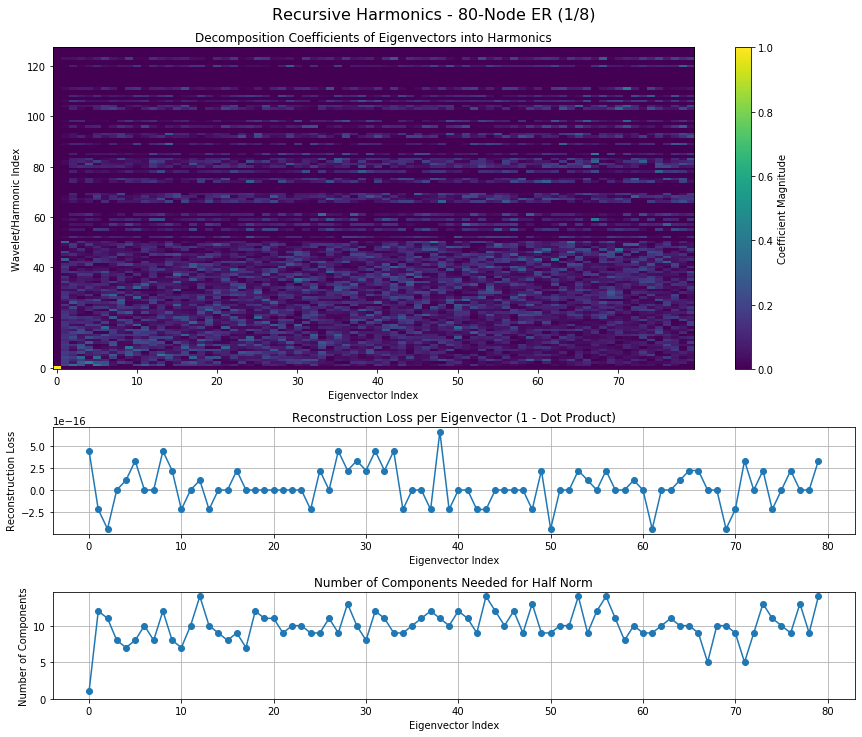

In [19]:
do_plot(eigvec_list, rec_orth, 'Recursive Harmonics - 80-Node ER (1/8)')

/home/bsw38/.conda/envs/benchmark_gnn_2/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


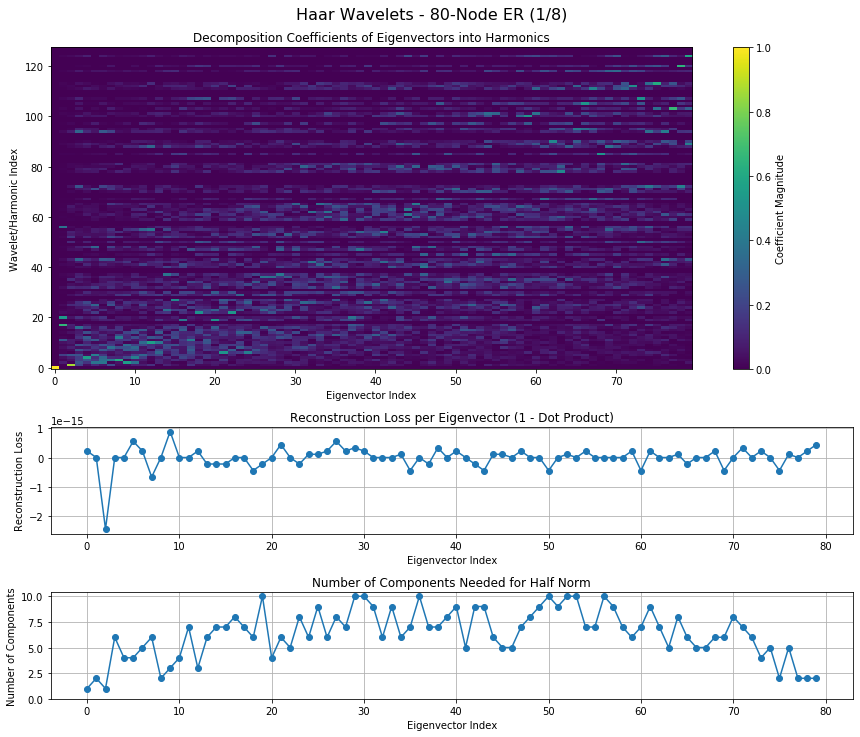

In [20]:
do_plot(eigvec_list, haar_orth, 'Haar Wavelets - 80-Node ER (1/8)')